## Inferring the mean of a Normal distribution

For this example, we will try to estimate the mean of a normally distributed random variable. To keep things simple, we will assume that we know the variance. This would make sense, if for example our data were IQ measurements, and we can assume that this trait has a standard deviation of 15.

As before, we will first work with randomly generated data:

In [5]:
# this makes sure we get the same random numbers every time
set.seed(34522)

n <- 20
y <- round(rnorm(n = n, mean = 120, sd = 15))
head(y, 10)

 [1] 126 112 118 114 152 120 135 110 121 108

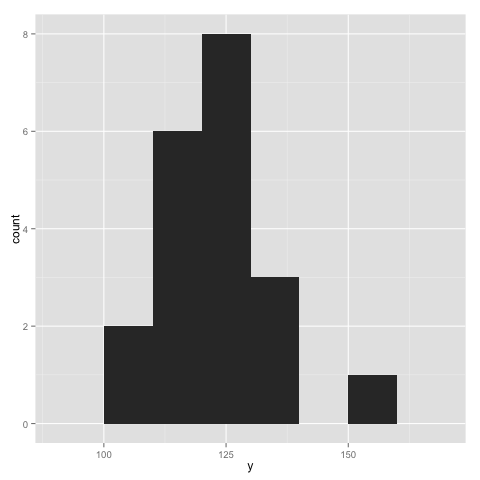

In [6]:
library(ggplot2)
qplot(y, geom = "histogram", binwidth = 10)

We know that $y$ is normally distributed, with mean $\mu$ and variance $\sigma^2$:

$$ y \sim Normal(\mu, \sigma^2)$$

Keep in mind that we are only trying to estimate $\mu$ in order to keep things simple. 

> NOTE: in Jags, the normal distribution parameterizes the Normal distribution using the precision $\tau$, which is the inverse of the variance $\sigma^2$

Therefore, in Jags we would write:

``` R 
y ~ Normal(mu, 1/sigma^2)
```

In fact, we can define `tau` like this:

``` R
tau <- pow(sigma, -2)
```
where `sd` is the standard deviation.

## Load package

First, we have to load the the relevant R packages.

In [4]:
library(dplyr)
library(tidyr)
library(R2jags)
library(ggmcmc)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: rjags
Loading required package: coda
Loading required package: lattice
Linked to JAGS 3.4.0
Loaded modules: basemod,bugs

Attaching package: ‘R2jags’

The following object is masked from ‘package:coda’:

    traceplot

Loading required package: ggplot2


## Model specification

In [15]:
modelstr <- "
model{
  for (i in 1:n_obs) { 
    y[i] ~ dnorm(mu, tau)
    }

    mu ~ dnorm(0, 1e-03) # prior

    sigma <- 15
    tau <- pow(sigma, -2) # 1/(sigma*sigma)
}"

In [16]:
jagsdata <- list(y = y,
                n_obs = length(y))

In [9]:
inits <- function() {
    list(mu = rnorm(1, 1, 1))
    }

In [10]:
parameters = "mu"

In [12]:
fit <- jags(data = jagsdata, model.file = textConnection(modelstr), 
             inits = inits, n.chains = 2,
             n.iter = 2000, n.thin = 2,n.burnin = 100,
             parameters.to.save = parameters)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
   Graph Size: 28

Initializing model



In [13]:
print(fit)

Inference for Bugs model at "5", fit using jags,
 2 chains, each with 2000 iterations (first 100 discarded), n.thin = 2
 n.sims = 1900 iterations saved
         mu.vect sd.vect    2.5%     25%     50%     75%   97.5%  Rhat n.eff
mu       121.062   3.326 114.398 118.929 121.087 123.289 127.359 1.001  1900
deviance 157.853   1.607 156.735 156.846 157.246 158.157 162.535 1.001  1900

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

DIC info (using the rule, pD = var(deviance)/2)
pD = 1.3 and DIC = 159.1
DIC is an estimate of expected predictive error (lower deviance is better).


## Inferring the mean and standard deviation of a Normal distribution

In [17]:
modelstr <- "
model{
  for (i in 1:n_obs) { 
    y[i] ~ dnorm(mu, tau)
    }

    mu ~ dnorm(0, 1e-03)

    sigma ~ dunif(0, 100) # sigma must be > 0
    tau <- pow(sigma, -2) # 1/(sigma*sigma)
}"

In [18]:
jagsdata <- list(y = y,
                n_obs = length(y))

In [19]:
inits <- function() {
    list(mu = rnorm(1, 1, 1),
         sigma = runif(1, 0, 100))
    }

In [20]:
parameters = c("mu", "sigma")

In [21]:
fit <- jags(data = jagsdata, model.file = textConnection(modelstr), 
             inits = inits, n.chains = 2,
             n.iter = 2000, n.thin = 2,n.burnin = 100,
             parameters.to.save = parameters)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
   Graph Size: 29

Initializing model



In [22]:
print(fit)

Inference for Bugs model at "6", fit using jags,
 2 chains, each with 2000 iterations (first 100 discarded), n.thin = 2
 n.sims = 1900 iterations saved
         mu.vect sd.vect    2.5%     25%     50%     75%   97.5%  Rhat n.eff
mu       121.258   2.934 115.242 119.423 121.295 123.157 126.720 1.001  1900
sigma     12.580   2.197   9.219  11.017  12.264  13.785  17.922 1.001  1900
deviance 156.620   2.455 154.338 154.952 155.842 157.346 163.347 1.005   940

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

DIC info (using the rule, pD = var(deviance)/2)
pD = 3.0 and DIC = 159.6
DIC is an estimate of expected predictive error (lower deviance is better).


## Repeated IQ measurement

In [23]:
true_iq <- 110
sd <- 5
n_subjects <- 10
person_iq <- round(rnorm(n_subjects, mean = true_iq, sd = sd))
person_iq

 [1] 114 110 104 107  98 101 108 110 104 116

In [24]:
measure_iq <- function(x, sd = 2, n_rep = 3) {
    round(rnorm(n_rep, x, sd))
}

In [25]:
df <- data.frame(sapply(X = person_iq, FUN = measure_iq , n_rep = 3))
colnames(df) <- c(paste("subj", 1:n_subjects, sep = ""))
df <- df %>% gather(subject, iq)

df$subj_idx <- match(df$subject, unique(df$subject))
df %>% head

  subject  iq subj_idx
1   subj1 113        1
2   subj1 113        1
3   subj1 116        1
4   subj2 111        2
5   subj2 107        2
6   subj2 108        2

In [26]:
modelstr <- "
model{
    for (i in 1:n_obs) { 
      y[i] ~ dnorm(mu[subject[i]], tau)
    }
    
    for (k in 1:n_subjects) { 
      mu[k] ~ dnorm(100, 1e-02)
    }
    
    sigma ~ dunif(0, 10) # sigma must be > 0
    tau <- pow(sigma, -2) # 1/(sigma*sigma)
}"

In [27]:
jagsdata <- list(y = df$iq,
                 subject = df$subj_idx,
                 n_subjects = length(unique(df$subj_idx)),
                 n_obs = length(df$iq))

In [28]:
inits <- function() {
    list(mu = rnorm(jagsdata$n_subjects, 1, 1),
         sigma = runif(1, 0, 10))
    }

In [29]:
parameters = c("mu", "sigma")

In [30]:
fit <- jags(data = jagsdata, model.file = textConnection(modelstr), 
             inits = inits, n.chains = 2,
             n.iter = 2000, n.thin = 2,n.burnin = 100,
             parameters.to.save = parameters)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
   Graph Size: 80

Initializing model



In [186]:
print(fit)

Inference for Bugs model at "4", fit using jags,
 2 chains, each with 2000 iterations (first 100 discarded), n.thin = 2
 n.sims = 1900 iterations saved
         mu.vect sd.vect    2.5%     25%     50%     75%   97.5%  Rhat n.eff
mu[1]    110.191   1.282 107.668 109.355 110.216 111.014 112.668 1.001  1900
mu[2]    105.518   1.247 103.004 104.693 105.536 106.380 107.943 1.006   290
mu[3]    114.097   1.264 111.650 113.243 114.088 114.875 116.608 1.000  1900
mu[4]    115.711   1.293 113.007 114.904 115.737 116.547 118.212 1.002  1300
mu[5]    115.081   1.249 112.569 114.291 115.091 115.849 117.614 1.001  1800
mu[6]    115.413   1.233 112.843 114.586 115.424 116.224 117.917 1.003   580
mu[7]    109.881   1.241 107.299 109.079 109.920 110.729 112.232 1.005  1100
mu[8]    105.601   1.231 103.139 104.820 105.604 106.388 107.976 1.001  1900
mu[9]    109.832   1.230 107.371 109.015 109.841 110.635 112.229 1.000  1900
mu[10]   111.133   1.287 108.622 110.324 111.150 111.920 113.698 1.002  1900
s

## Hierarchical example: repeated IQ measurements

In [31]:
modelstr <- "
model{
    for (i in 1:n_obs) { 
      y[i] ~ dnorm(mu[subject[i]], tau)
    }
    
    for (k in 1:n_subjects) { 
      mu[k] ~ dnorm(group_mu, group_tau)
    }
    
    group_mu ~ dnorm(100, 1e-02)
    group_sigma ~ dunif(0, 10)
    group_tau <- pow(group_sigma, -2)

    sigma ~ dunif(0, 100) # sigma must be > 0
    tau <- pow(sigma, -2) # 1/(sigma*sigma)
}"

In [32]:
jagsdata <- list(y = df$iq,
                 subject = df$subj_idx,
                 n_subjects = length(unique(df$subj_idx)),
                 n_obs = length(df$iq))

In [33]:
inits <- function() {
    list(group_mu = rnorm(1, 100, 15),
         group_sigma = runif(1, 0, 10),
         sigma = runif(1, 0, 100))
}

In [34]:
parameters = c("group_mu", "group_sigma", "mu", "sigma")

In [35]:
fit <- jags(data = jagsdata, model.file = textConnection(modelstr), 
             inits = inits, n.chains = 2,
             n.iter = 2000, n.thin = 2,n.burnin = 100,
             parameters.to.save = parameters)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
   Graph Size: 83

Initializing model



In [192]:
print(fit)

Inference for Bugs model at "5", fit using jags,
 2 chains, each with 2000 iterations (first 100 discarded), n.thin = 2
 n.sims = 1900 iterations saved
            mu.vect sd.vect    2.5%     25%     50%     75%   97.5%  Rhat n.eff
group_mu    111.211   1.468 108.300 110.323 111.237 112.102 114.103 1.007  1900
group_sigma   4.359   1.344   2.459   3.409   4.111   5.019   7.954 1.004  1800
mu[1]       110.422   1.179 108.132 109.638 110.434 111.213 112.708 1.000  1900
mu[2]       106.221   1.196 103.953 105.418 106.185 106.986 108.628 1.001  1900
mu[3]       114.008   1.212 111.558 113.207 114.006 114.823 116.327 1.001  1900
mu[4]       115.615   1.236 113.148 114.841 115.668 116.404 118.022 1.001  1900
mu[5]       114.952   1.214 112.476 114.180 114.973 115.748 117.261 1.000  1900
mu[6]       115.280   1.214 112.827 114.529 115.306 116.080 117.722 1.003   710
mu[7]       110.084   1.187 107.778 109.272 110.074 110.867 112.470 1.000  1900
mu[8]       106.177   1.245 103.773 105.317 106.

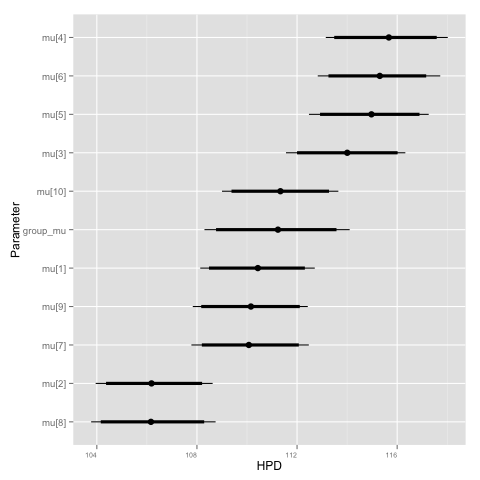

In [197]:
ggs_caterpillar(ggs(as.mcmc(fit)), family = "mu")